In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

plt.ion()   

In [2]:
from  torchvision import datasets

cifar_trainset = datasets.CIFAR10(root='./data', train=True, download=True  )
data = cifar_trainset.data / 255 # data is numpy array

mean = data.mean(axis = (0,1,2)) 
std = data.std(axis = (0,1,2))
print(f"Mean : {mean}   STD: {std}")

Files already downloaded and verified
Mean : [0.49139968 0.48215841 0.44653091]   STD: [0.24703223 0.24348513 0.26158784]


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training dataset
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(root='.', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((mean), (std))
                   ])), batch_size=64, shuffle=True, num_workers=4)
# Test dataset
test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(root='.', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((mean), (std))
    ])), batch_size=64, shuffle=True, num_workers=4)

Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class STN(nn.Module):
    def __init__(self):
        super(STN, self).__init__()
        # simple convnet classifier
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

        # spatial transformer localization network
        self.localization = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # tranformation regressor for theta
        self.fc_loc = nn.Sequential(
            nn.Linear(128*4*4, 256),
            nn.ReLU(True),
            nn.Linear(256, 3 * 2)
        )

        # initializing the weights and biases with identity transformations
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0],  dtype=torch.float))

    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, xs.size(1)*xs.size(2)*xs.size(3))

        # calculate the transformation parameters theta
        theta = self.fc_loc(xs)
        # resize theta
        theta = theta.view(-1, 2, 3) 
        # grid generator => transformation on parameters theta
        grid = F.affine_grid(theta, x.size())
        # grid sampling => applying the spatial transformations
        x = F.grid_sample(x, grid)

        return x

    def forward(self, x):
        # transform the input
        x = self.stn(x)
        
        # forward pass through the classifier 
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))g
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

In [5]:
model = STN().to(device)

In [6]:
from torchsummary import summary
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 26, 26]           9,472
         MaxPool2d-2           [-1, 64, 13, 13]               0
              ReLU-3           [-1, 64, 13, 13]               0
            Conv2d-4            [-1, 128, 9, 9]         204,928
         MaxPool2d-5            [-1, 128, 4, 4]               0
              ReLU-6            [-1, 128, 4, 4]               0
            Linear-7                  [-1, 256]         524,544
              ReLU-8                  [-1, 256]               0
            Linear-9                    [-1, 6]           1,542
           Conv2d-10            [-1, 6, 28, 28]             456
        MaxPool2d-11            [-1, 6, 14, 14]               0
           Conv2d-12           [-1, 16, 10, 10]           2,416
        MaxPool2d-13             [-1, 16, 5, 5]               0
           Linear-14                  [

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4066: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


In [7]:
optimizer = optim.SGD(model.parameters(), lr=0.01)

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
#
# A simple test procedure to measure STN the performances on MNIST.
#


def test():
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # sum up batch loss
            test_loss += F.nll_loss(output, target, size_average=False).item()
            # get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
              .format(test_loss, correct, len(test_loader.dataset),
                      100. * correct / len(test_loader.dataset)))

In [16]:
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.49139968, 0.48215841, 0.44653091])
    std = np.array([0.24703223, 0.24348513, 0.26158784])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

# We want to visualize the output of the spatial transformers layer
# after the training, we visualize a batch of input images and
# the corresponding transformed batch using STN.


def visualize_stn():
    with torch.no_grad():
        # Get a batch of training data
        data = next(iter(test_loader))[0].to(device)

        input_tensor = data.cpu()
        transformed_input_tensor = model.stn(data).cpu()

        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))

        # Plot the results side-by-side        
        f, axarr = plt.subplots(1, 2, figsize=(22,10))
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4066: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify ali

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.306755
Train Epoch: 1 [32000/50000 (64%)]	Loss: 2.266165


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 2.1279, Accuracy: 2229/10000 (22%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 2.130422
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.804982

Test set: Average loss: 1.8239, Accuracy: 3175/10000 (32%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.744722
Train Epoch: 3 [32000/50000 (64%)]	Loss: 1.594820

Test set: Average loss: 1.7202, Accuracy: 3782/10000 (38%)

Train Epoch: 4 [0/50000 (0%)]	Loss: 1.700610
Train Epoch: 4 [32000/50000 (64%)]	Loss: 1.608032

Test set: Average loss: 1.5674, Accuracy: 4196/10000 (42%)

Train Epoch: 5 [0/50000 (0%)]	Loss: 1.656767
Train Epoch: 5 [32000/50000 (64%)]	Loss: 1.376528

Test set: Average loss: 1.5566, Accuracy: 4358/10000 (44%)

Train Epoch: 6 [0/50000 (0%)]	Loss: 1.560276
Train Epoch: 6 [32000/50000 (64%)]	Loss: 1.470433

Test set: Average loss: 1.4476, Accuracy: 4679/10000 (47%)

Train Epoch: 7 [0/50000 (0%)]	Loss: 1.299575
Train Epoch: 7 [32000/50000 (64%)]	Loss: 1.265339

Test set: Average loss: 1.4582, Accuracy: 4848/10000 (48%)

Tra

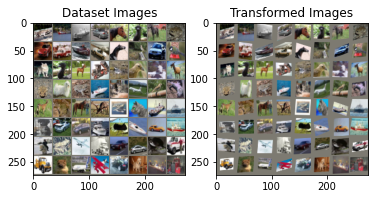

In [9]:
for epoch in range(1, 50 + 1):
    train(epoch)
    test()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4066: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify ali

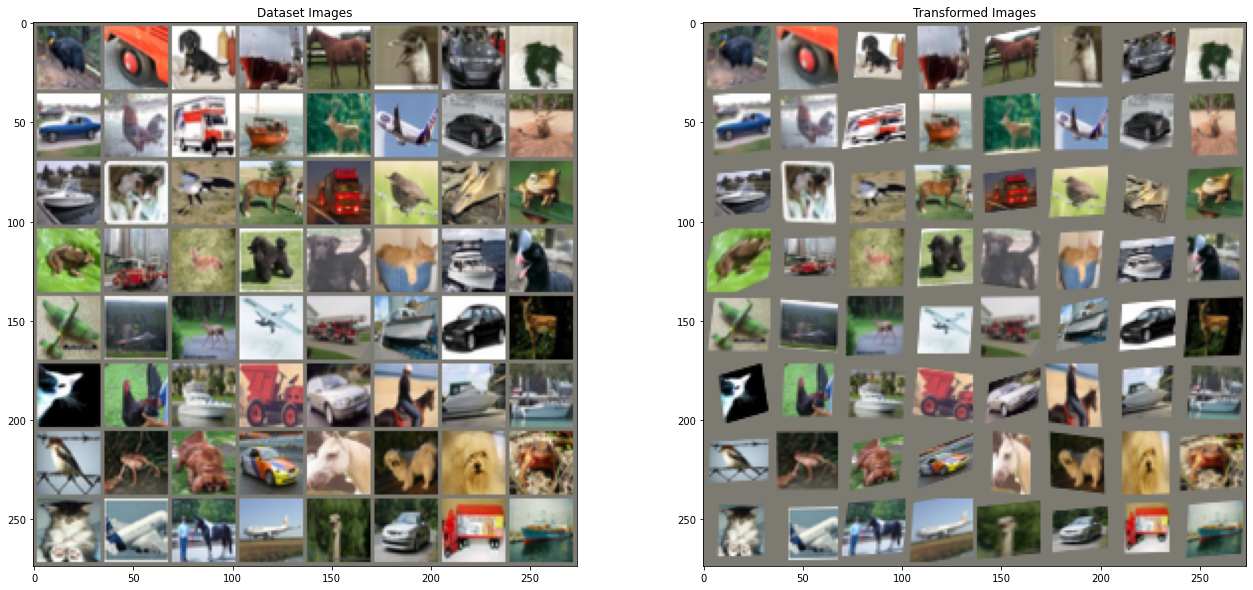

In [17]:
# Visualize the STN transformation on some input batch
visualize_stn()

plt.ioff()
plt.show()